# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

*Anoushka Ghosh, Keith Tung, Jonathan Hoover, Rebekah Kiner*

# 0. Setup

In [33]:
import os

In [34]:
%%capture
!pip install pycountry

In [35]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import pycountry as pc

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

##missingness library
import missingno

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier


In [36]:
# Load data
d = pd.read_csv("hotel.csv")

##create copy of data
df = d.copy()

# 1. Introduction


The aim of this project is to construct a predictive model that will accurately predict hotel booking cancellations. In the hotel booking world, booking cancellations are very common. These cancellations cause a loss in revenue and make it difficult to run a profitable hotel business. Thus, hotels must take precautions/create special cancellation policies to help lessen the revenue loss due to cancellations. This report aims to help hotels understand what steps they can take to implement measures that will mitigate the high cancellation rates and, thus, mitigate loss of revenue.

The data used in this project for hotel booking cancellations comes from the booking systems of two real hotels and reflect bookings made between July 1st, 2015 through August 31st, 2017. No additional data was used for this report.

First the data needs to be cleaned before it can be used in a model. This included taking out duplicates, replacing/dropping the missing values (since the authors of the data suggested that this data has no missing values), and checking for any data entry errors.

Once the data was cleaned, feature engineering and exploratory data analysis was done. Here we introduce new columns with new categories based on old features, convert categorical features from floats to categories(binary and non-binary using OneHotEncoder) and visualize the different features based on cancellation status, etc. Additionally in this section, we standardize and split the data into training and test sets.

Following feature engineering, the data was fit to several different models. The most efficient and most accurate model was the Random Forest Classifier. From this model, the features which seemed to affect hotel cancellations the most were Country, Market Segment, Lead time and Total number of Special Requests. 

# 2. Exploratory Data Analysis and Feature Engineering

## *Data Cleaning*

This dataset is a real dataset, so there are bound to be issues with data quality that need to be cleaned. The first step to understand what data cleaning is required is to probe the data structure. 

In [37]:
%%capture
#Description of data 
df.info()

| Col# |  Column        |Non-Null Count | Dtype | Description|
|---|  ------        |-------------- | ----- | -----------|
| 0 |  is_canceled        |119390 non-null   | int64 | Value indicating if the booking was canceled (1) or not (0)|
| 1 |  hotel       |119390 non-null   | object | Hotel (Resort Hotel or City Hotel)|
| 2 |  lead_time   |119390 non-null   | int64| Number of days that elapsed between the entering date of the booking into the PMS and the arrival date|
| 3 |  arrival_date_year      |119390 non-null   |int64| 	Year of arrival date|
| 4 |  arrival_date_month        |119390 non-null   | object| 	Month of arrival date|
| 5 |  arrival_date_week_number    |119390 non-null   |int64| Week number of year for arrival datee|
| 6 |  arrival_date_day_of_month   |119390 non-null   | int64 | 	Day of arrival date
| 7 |   stays_in_weekend_nights      |119390 non-null   | int64| 	Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel|
| 8 |  stays_in_week_nights       |119390 non-null   | int64 | 	Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
| 9 |  adults  |119390 non-null   | int64 | 	Number of adults|
| 10|  children       |119390 non-null   | float64 | 	Number of children|
| 11|  babies  |119390 non-null   | int64 | 	Number of babies|
| 12|  meal   |119390 non-null   | object| Type of meal booked. | 
| 13 |  country   |1118902 non-null   | object | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
| 14 |  market_segment     |119390 non-null   | object| Market segment designation. In categories, the term TA means “Travel Agents” and TO means “Tour Operators”|
| 15 |  distribution_channel      |119390 non-null   | object | Booking distribution channel. The term TA means “Travel Agents” and TO means “Tour Operators”|
| 16 |  is_repeated_guest  |119390 non-null   | int64 | Value indicating if the booking name was from a repeated guest (1) or not (0)|
| 17|  previous_cancellations       |119390 non-null   | int64 | 	Number of previous bookings that were cancelled by the customer prior to the current booking|
| 18|  previous_bookings_not_canceled   |119390 non-null   | int64 | Number of previous bookings not cancelled by the customer prior to the current booking|
| 19|  reserved_room_type    |119390 non-null   | object | Code of room type reserved. Code is presented instead of designation for anonymity reasons
| 20 | assigned_room_type   |119390 non-null   | object | Code for the type of room assigned to the booking. Sometimes the assigned room type differs <br> from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. <br> Code is presented instead of designation for anonymity reasons|
| 21 |   booking_changes        |119390 non-null   | int64 | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS <br> until the moment of check-in or cancellation|
| 22|  deposit_type  |119390 non-null   | object | Indication on if the customer made a deposit to guarantee the booking.|
| 23|  agent    |103050 non-null   | float64| ID of the travel agency that made the booking
| 24 |  company  |6797 non-null   | float64 | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented <br> instead of designation for anonymity reasons|
| 25|  days_in_waiting_list      |119390 non-null   | int64 | Number of days the booking was in the waiting list before it was confirmed to the customer|
| 26|  customer_type   |119390 non-null   | object | Type of booking, assuming one of four categories:|
| 27|  adr    |119390 non-null   | float64| Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
| 28| required_car_parking_spaces |119390 non-null   | int64 | Number of car parking spaces required by the customer|
| 29|  total_of_special_requests     |119390 non-null   | int64| Number of special requests made by the customer (e.g. twin bed or high floor)

There are 29 columns. One of the columns is the response column, "is_canceled", which takes values of 0 and 1. 1 indicates a booking that was cancelled and 0 indicates a booking that was not cancelled. There are 28 feature columns describing the characteristics of the data. Since this is real data, we will check for missingness and any unexpected deviations in structure (dupicates, strings that are misspelled, etc.). We will check for duplicate observations first.

In [38]:
##Identify duplicates
print("Count of Duplicated Observations: ")
print(df.duplicated().sum())
print("\n")

##print example of duplicates
print("Example of Duplicates:\n")
df[df.duplicated(keep = False)].head(2) ##show first two


Count of Duplicated Observations: 
32252


Example of Duplicates:



,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1
5,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


There are 32252 duplicated observations. 

As this is real data, there is the slight chance that two different bookings have the exact same data since we are not given a customer ID (see example above). However, since the data includes lead_time, arrival_date_year, arrival_date_week_number, and other very specific identifying characteristics, we can be confident that any duplicates are actual duplicates and not two different customers with the same data. Considering these are likely true duplicates, we will drop them.

In [39]:
##drop duplicates
df = df.drop_duplicates(keep = 'first')
print("Number of Unique Observations:")
print(df.shape[0])

Number of Unique Observations:
87138


After dropping duplicates we have 87138 unique observations. Next we will look at missingness.

In [40]:
##Get overall missingness
print("Missing Data Counts:")
print(df.isna().sum()[df.isna().sum() > 0]) ##print only non-zero values
print("\n")

Missing Data Counts:
children        4
country       451
agent       12160
company     81890
dtype: int64




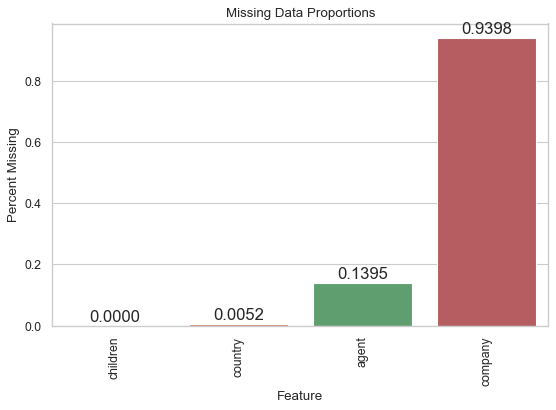

In [41]:
##find proportion of missing values for missing data
missing_df= df.isnull().sum() / len(df)
missing_df = missing_df[missing_df > 0]
missing_df.sort_values(inplace=True)
missing_df = pd.DataFrame(data=missing_df)
missing_df.columns = ['Percent Missing']
missing_df.index.names = ['Feature']
missing_df
missing_df['Feature'] = missing_df.index

##Plot Missingness
sns.set(style="whitegrid", color_codes=True)
chart = sns.barplot(x = 'Feature', y = 'Percent Missing', data=missing_df)

##The following code was taken from:
##https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Iterrating over the bars one-by-one
for bar in chart.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    chart.annotate(format(bar.get_height(), '.4f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
chart.set(title = "Missing Data Proportions")
plt.xticks(rotation = 90)
plt.show()

The plots above show that "children", "country", "agent", and "company" are missing. The rest of the features are fully observed. Of the missing data, agent and company show the largest proportion missing while children and country are mostly complete. 

**The paper states that no missing data is present**. Specifically, they mention that "Null" data in the company and agent category is actually their own category specifying that no company or agent was used. As such we will create a new category for these. We will deal with children and country after this.

In [42]:
##Fill misssing data with new category called "Not Used"
missing_cols = ["company", "agent"]
for i in missing_cols:
    df[i] = df[i].fillna("Not Used") ##Fill "NA" with new variable
    df[i] = df[i].astype('str') ##Change to str for categorical classification
    df[i] = df[i].astype('object') ##Change to object for categorical classification

print("Number of Missing Company Values After 'Fill':")
print(df["company"].isna().sum())
print("Number of Unique Company Values:")
print(df["company"].nunique())
print("-------------------------------------------------")
print("Number of Missing Agent Values After 'Fill'")
print(df["agent"].isna().sum())
print("Number of Unique Agent Values:")
print(df["agent"].nunique())

Number of Missing Company Values After 'Fill':
0
Number of Unique Company Values:
353
-------------------------------------------------
Number of Missing Agent Values After 'Fill'
0
Number of Unique Agent Values:
334


We can see that we have filled each missing value for company and agent. After filling, there are 353 unique company values and 334 unique agent values.

Next we need to solve the missingness in children and country.

Children only had 4 missing values, so we can confidently drop these since 4 out of 87138 observations is not enough to affect the interpretation. This is done below.

In [43]:
##Dropping missing "children" observations since there are only 4
print("Size Before Dropping Missing Children Observations:")
print(df.shape[0])
df = df.loc[df["children"].isna() == False,:]
print("Size After Dropping Missing Children Observations:")
print(df.shape[0])

Size Before Dropping Missing Children Observations:
87138
Size After Dropping Missing Children Observations:
87134


There were 451 missing values in country. We could perform imputation on these data; however, since the authors of the paper say there is not supposed to be missingness, we don't want to impute in case this missingness is predictive. As such, we will create a new level for these missing countries called "Undefined" and let that be a predictor in itself. This is done below.

In [44]:
##rename missing values in "country" as undefined to let it be its own level
df["country"].loc[df["country"].isna()] = "Undefined"
print("Checking Missing Values in Country after 'Fill':")
print(df["country"].isna().sum())

Checking Missing Values in Country after 'Fill':
0


Now that we have filled (or dropped) all missing data, we should have a fully observed dataset. To confirm, we count the total missing observations below.

In [45]:
##Count remaining missing data
print("Remaining Missing Observations:")
print(df.isna().sum().sum())

Remaining Missing Observations:
0


As we can see, there is no more missing data.

Because this is real data, there could be data entry errors, particularly with text. As such, the last step for data cleaning is to check the string values to ensure there is no improper formatting. The unique values of each string variable are printed below to check for issues with capitalization, spelling, and spacing. 

In [46]:
#check unique values of strings to see if any strings are formatted weird
#Exlude agent and company because we already know they are formatted correctly and they have too many levels to print
string_cols = df.drop(columns = ["agent", "company"]).select_dtypes(["object"]).columns

uniquevals = {}
for col in string_cols:
    uniquevals[col] = df[col].unique()
    
##Reformat for easy viewing
for key, value in uniquevals.items():
    print(f'{key}{value}')

hotel['Resort Hotel' 'City Hotel']
arrival_date_month['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal['BB' 'FB' 'HB' 'SC' 'Undefined']
country['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'Undefined' 'ROU' 'NOR' 'OMN' 'ARG'
 'POL' 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS'
 'EST' 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX'
 'MAR' 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF'
 'AGO' 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN'
 'JAM' 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'
 'GGY' 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL'
 'SEN' 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA'
 'CUB' 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP'
 'BDI' 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL'
 'UZB' 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH'

The results suggest that our data is sufficiently clean (no weirdly formatted strings that are actually duplicate values but misspelled) to proceed. Now that the data is clean, we will proceed with feature engineering and exploratory data analysis related to our response variable, "is_canceled".

## *Feature Engineering and Exploratory Data Analysis*

To improve classification, we may need to perform some data transformations. Some variables that lend themselves to transformation are "children", "babies", "agent", and "company". It makes intuitive sense that the presence of a child or baby may influence the cancellation status (children are more likely to get sick or families with children are more likely to commit to a vacation; either is possible). Additionally, while individual agents and companies may influence the likelihood of cancellation, the presence or absence of these services may also influence cancellation. As such we will create binary variables for each of these and then assess their role in cancellation status to decide if we should keep them. Below we create the binary variables: "Children Present", "Baby Present", "Agent Used", "Company Used"

In [47]:
##create new variable for children present, baby present, agent used, company used
binary_nums = ["children_present", "baby_present"]
binary_cats = ["company_used", "agent_used"]
nonbinary_nums = ["children", "babies"]
nonbinary_cats = ["company", "agent"]

##for baby and children (numericals)
for i in range(len(binary_nums)):
    df[binary_nums[i]] = np.where(df[nonbinary_nums[i]] > 0, np.int64(1), np.int64(0))

##for company and agent (categoricals)
for i in range(len(binary_cats)):
    df[binary_cats[i]] = np.where(df[nonbinary_cats[i]] != 'Not Used', np.int64(1), np.int64(0))

Lastly, we will define a new column called "group_type" to characterise the type of group the booking belongs to. There will be 3 levels: 1) "Single_User": Only one adult 2) "Family": At least one adult and at least one child or baby 3) "Adult_Group": More than one adult with no children or babies.

The idea here is that different group types have different chances of cancelling. Single occupants and families book together, so they are less likely to cancel independently; however, groups of adults might have different members cancel independently, which could cause a cancellation overall.

In [48]:
df["group_type"] = np.where((df["children"] == 0) & (df["babies"] == 0) & (df["adults"] > 1), "Adult_Group",
                   np.where(((df["children"] > 0) | (df["babies"] > 0)) & (df["adults"] > 0), "Family",
                   np.where((df["children"]) == 0 & (df["babies"] == 0) & (df["adults"] == 1), "Single_User",
                   np.where(df["adults"] == 0, "Zero Adults", "Not Valid"))))

We will now check what types of groups were created to confirm that our data matches the expected structure (There should not be any observations with zero adults or no children; if this is the case, it might be predictive).

In [49]:
##Count of unique types
print("Count of Unique Types:")
print(df.group_type.value_counts())

print("\n")
print("Sum of Counts:")
print(df.group_type.value_counts().sum())

print("Total Observations:")
print(df.shape[0])

Count of Unique Types:
Adult_Group    61863
Single_User    16180
Family          8872
Zero Adults      219
Name: group_type, dtype: int64


Sum of Counts:
87134
Total Observations:
87134


Overall, the total number of unique counts matches the observations, so the column has been created correctly. As we can see, there are groups for "Zero Adults" (No "Not Valid" groups were created). We need to inspect these cases to see what is happening.

In [50]:
print("\n")
print("'Zero Adult' Groups:")
print(df[["adults", "children", "babies"]].iloc[np.where(df["group_type"] == "Zero Adults")])



'Zero Adult' Groups:
        adults  children  babies
40984        0       3.0       0
41048        0       2.0       0
41446        0       2.0       0
41952        0       2.0       0
45158        0       2.0       0
...        ...       ...     ...
117204       0       2.0       0
117274       0       2.0       0
117303       0       2.0       0
117453       0       2.0       0
118200       0       3.0       0

[219 rows x 3 columns]


The "Zero Adult" group is concerning since we would expect each reservation to require an adult. However, the definition of adult may vary at hotels (ie if adult age is 25, a 21 year-old could book, but would be considered a youth). As such, we will not drop and we will consider this it's own level. It may provide predictive value.

We'd like to check whether these data transformations are valuable transformations, so we will perform some initial exploratory data analysis between our outcome variable, "is_canceled", and our feature variables.

First, we'd like to check the proportion of cancelations and kept reservations per category in each categorical variable. The data will help us identify potentially important variables. Note that we do not plot country, company, or agent because there are too many levels to make sense of in a bar plot.

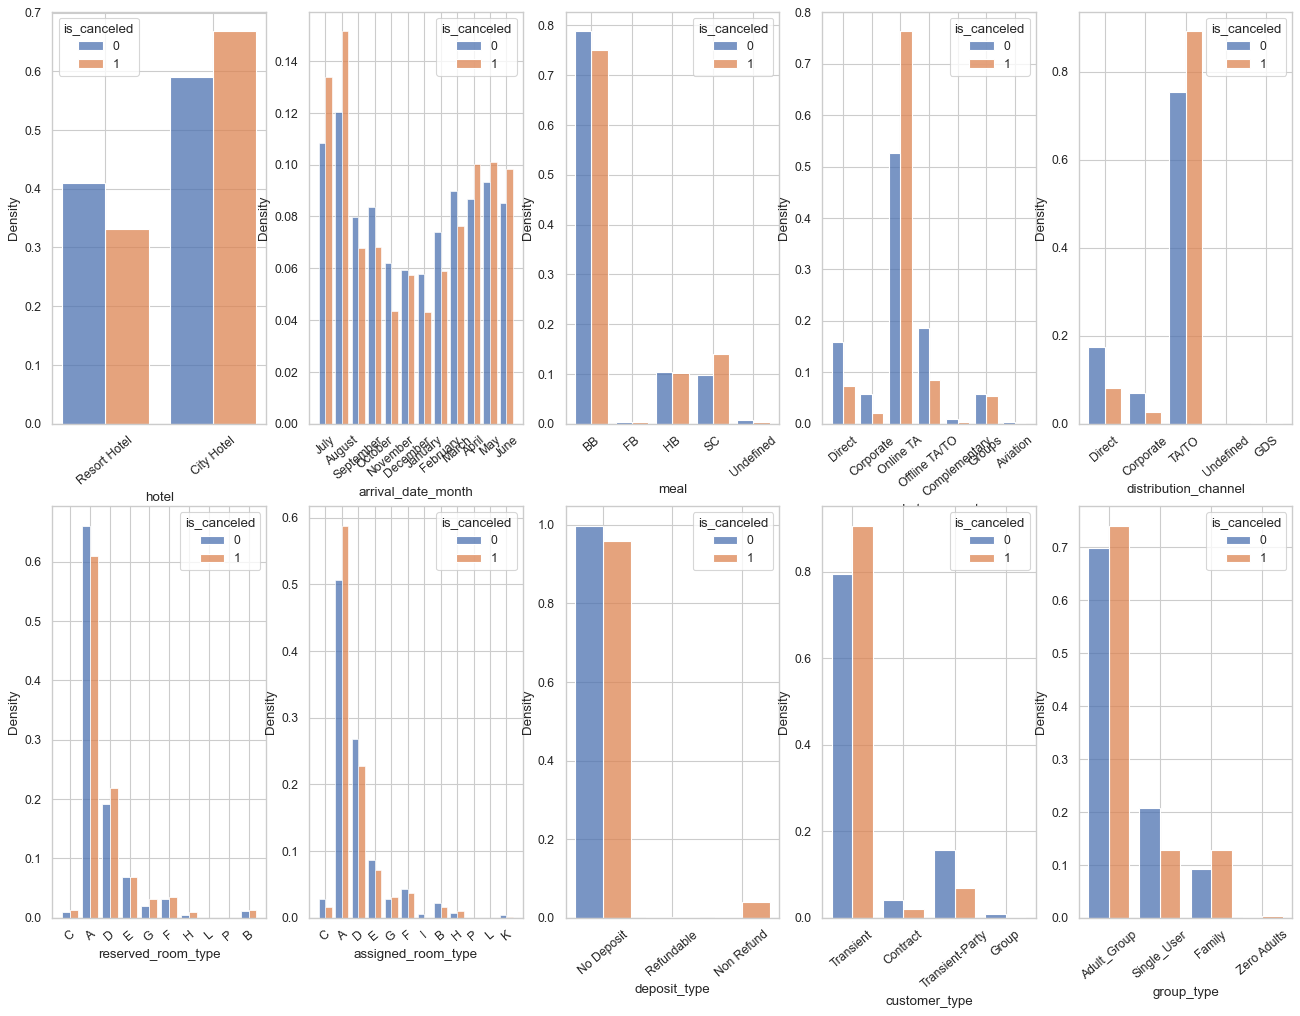

In [51]:
##plot categorical variables split by cancellation status
fig, ax = plt.subplots(ncols = 5, nrows =2, figsize = (20, 15))
ax = ax.ravel()
obj_cols = df.select_dtypes(["object", "category"]).columns 
obj_cols = [cols for cols in obj_cols if cols not in ["company", "agent", "country"]] ##Not plotting company, agent, or company because too many levels

for i in range(len(obj_cols)):
#   g = sns.countplot(x=obj_cols[i], hue = "is_canceled", data = df, ax = ax[i])
    g = sns.histplot(x = obj_cols[i], hue="is_canceled", multiple="dodge", data = df, ax = ax[i],
                     stat = 'density', shrink = 0.8, common_norm=False)
    for item in g.get_xticklabels():
        item.set_rotation(40)
    g

Some of the categorical variables don't appear to have much of an impact like meal type (The distributions of cancelled and not cancelled are relatively similar for each sub-group). However, other variables do seem to explain cancellation status fairly well. For instance, cancellation appears to be more likely at city hotels and less likely at resort hotels. Additionally, market segment (particularly online TA), distribution channel (again particularly TA/TO), customer type (particularly transient), and group_type (particularly Single_User) appear to explain cancellation status somewhat. The specific impact can be identified in the plots above. The identified variables might be useful in the prediction stage.

We also looked at the distribution of numerical variables by the cancellation status to see if any might be good predictors. We are reporting only "lead_time" and "adr" here because they were the only ones with visible differences.

<AxesSubplot:xlabel='is_canceled', ylabel='adr'>

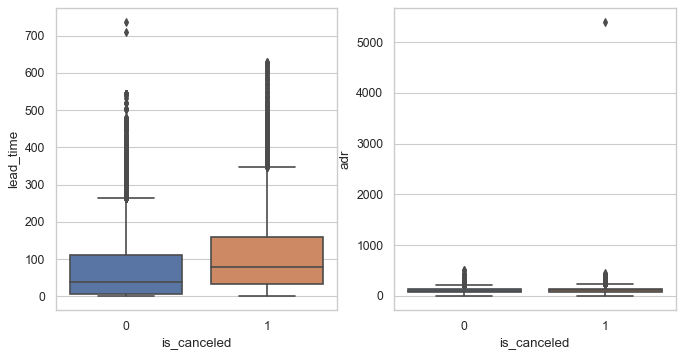

In [52]:
fig, ax2 = plt.subplots(ncols = 2, nrows =1, figsize = (10,5))
ax2 = ax2.ravel()

sns.boxplot(y="lead_time", x = "is_canceled", data = df, ax = ax2[0])
sns.boxplot(y="adr", x = "is_canceled", data = df, ax = ax2[1])

Most of the numerical variables don't appear to explain cancellation status very well (equal distributions among both cancellation groups), so we only show lead time and adr. However, lead time and adr appear to have some impact, so they will likely play a role in the prediction. We must note that while some variables may not appear to have an impact on classification status, the effect may just not be visible to the human eye, so we should rely upon the model to identify impact.

Lastly, we'd like to look at correlations (for numerical variables since we can't look for categorical variables). This should help us decide which numerical variables to keep.

<AxesSubplot:>

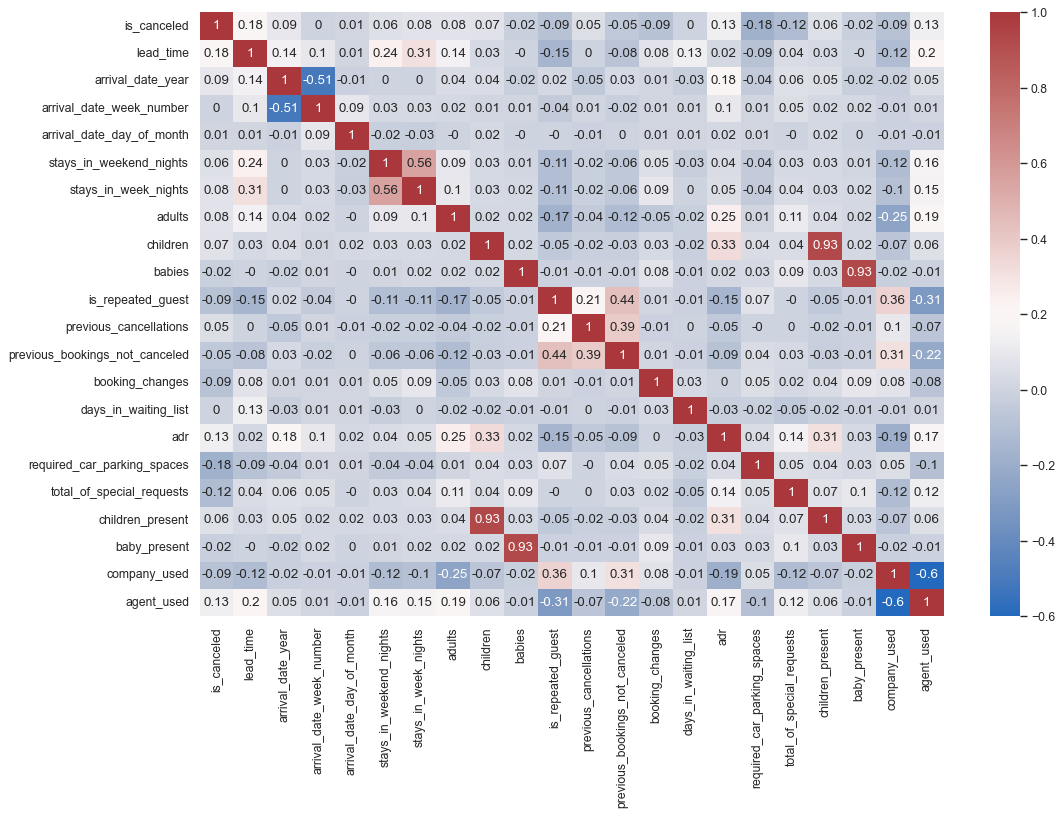

In [53]:
##correlation between numerical features ONLY
plt.figure(figsize=(15, 10))
sns.heatmap(round(df.select_dtypes(["int64", "float64", "int32", "float32"]).corr(), 2), annot = True, cmap = "vlag")

We will not explore each of these correlations; however, a few are worth noting.

The correlation plot shows a fair amount of correlation between is_canceled and requested_parking_spaces, is_canceled and total_of_special_requests, and is_canceled and agent_used. Consequently, these variables will likely be important for predicting cancellation status.

Additionally, from the binary variables we created earlier (children_present, baby_present, company_used, agent_used), only agent_used had a fairly high correlation with is_canceled. Consequently, we can drop children_present, baby_present, and company_used since the numeric variables corresponding to these contain similar information. Although agent_used appears to be correlated with the outcome, the agents column contains similar information (but more since there are more levels); consequently, we will also drop agent_used. 

Although there are additional correlations, we won't drop any other variables based on correlation because they tell slightly different pieces of information that might inform cancellation status.

Since we are dropping variables here, we will also drop any variables that can not provide predictive value. In this case, arrival_date_year does not provide predictive value since the years contained in the training set will never be available on new data. Consequently, we will also drop arrival_date_year. 

These features are dropped below. (Note that we need the arrival_date_year for a join we do for later analysis, so we are creating a portion of this dataframe now as well

In [54]:
##create a time dataframe to be used later in the analysis
timedf = df.copy()
timedf["date"] = pd.to_datetime(timedf.arrival_date_day_of_month.astype(str) + "-"  + timedf.arrival_date_month + "-" + timedf.arrival_date_year.astype(str))
timedf.index = timedf["date"]
timedf.reset_index(drop = True, inplace = True)

##drop the columns we defined
df = df.drop(columns = ["children_present", "baby_present", "company_used", "agent_used", "arrival_date_year"])


Before creating a model, we need to perform one last feature engineering step: We need to create dummy variables for our categorical variables with the OneHotEncoder. However, before creating the dummy variables we need to save the names of the columns that we will want to standardize since the OneHotEncoder creates too many columns to deal with at once.

After this we will need to split and standardize the numerical data for model building.

In [55]:
#select columns that require scaling
##First we select all numeric variables, but these contain dummy variables, which we do not want to scale
##So then we identify dummy variables (All dummies are numeric, but binary)
##and select from numerics, if NOT a dummy variable

X_init = df.drop("is_canceled", axis = 1) ##remove the response variable because we don't want to scale
scale_col = X_init.select_dtypes(include = np.number) ##subset the numeric columns

##Manually specify the categorical variables with numeric values since there is no common pattern
numeric_cats = ["arrival_date_week_number", "arrival_date_day_of_month", ##don't scale time series
               "is_repeated_guest"]

##select drop the numeric categoricals from scale_col
scale_col = [col for col in scale_col if col not in numeric_cats] ##update scale_col with true numeric variables

Now we create the dummy variables with the OneHotEncoder

In [56]:
#OneHotEncoding 
df.reset_index(inplace=True, drop = True)
ohe_col = df.select_dtypes(exclude = np.number).columns
ohe = OneHotEncoder(sparse = False)
dohe = ohe.fit_transform(df[ohe_col])
dohe = pd.DataFrame(dohe)
dohe.columns = ohe.get_feature_names_out()
df = pd.concat([df,dohe], axis = 1).drop(ohe_col, axis = 1)

We will now standardize the true numerical columns (ie non-binary numerical columns)

In [57]:
SEED = 332

##Split Data
#ESeparate response and explanatory data
X= df.drop("is_canceled", axis = 1) ##drop the response data from x
y = df["is_canceled"] ##select the response data

X = X.reset_index(drop = True)##reset indices on X

#Split data into train and test sets 
##We have a very large test set, so we don't need a very large test size
##We have an imbalanced dataset with more cancellations than non-cancellations, so we need to do a stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = SEED, stratify = y)

##Standardize data

##create copies to transform and keep as standardized data
std_train = X_train.copy() 
std_test = X_test.copy() 

# create pipeline for scalers
std_scale = Pipeline([('standard', StandardScaler())]) ##standardized scaling

##fit to training data (only scale columns)
std_scale.fit(X_train[scale_col]) ##fit to the training data

##transform training and test scale cols accroding to train data
std_train[scale_col] = std_scale.transform(std_train[scale_col])
std_test[scale_col] = std_scale.transform(std_test[scale_col])

##write to csv
# std_train.to_csv(f"./X_train_std.csv", index=False)
# std_test.to_csv(f"./X_test_std.csv", index=False)

# 3. Model Fitting and Tuning

## *Final model: Random Forest classifier*

One of the biggest challenges of building a model for this data is its size, both in length and width. After our feature engineering, our training set (75% of the data) consists of 65350 observations and 945 features. This size caused computational issues with some potential models like Naive Bayes and logistic regression. Additionally, it made it difficult to tune models. After many trials, we eventually settled on the Random Forest Classifier due to its relatively efficient training and interpretability.

### *What is a good model*
In the hospitality industry, cancellations are very common. Hotels often overbook their tickets or rooms, expecting cancellations to occur. This is to make sure that even with cancellations, the hotel still maximizes profit. While the most desirable outcome for a hotel is to have no cancellations and no vacant rooms, this is not a feasible outcome. One could argue the second-best outcome is an overbooked hotel so that each room is occupied even with cancellations (this priority may change depending on concern for unhappy customers, but we will assume overbooking is the optimal outcome).

Consequently, we would like to optimize our predictive model for accurate prediction of cancellation rather than non-cancellation; in other words, we want a highly sensitive rather than specific model (potentially overestimating cancellations). This way we can identify how many rooms to overbook to compensate for the potential loss from cancellations. Since we care more about increasing true positives than reducing false positives we have emphasized the recall for cancellations (proportion of actual positive identified)  instead of precision (proportion of positive predictions that were correct).

## *Model tuning*

### *Sample weight*
Although each observation is one booking, we assume that bookings will be valued differently by the hotel depending on the length of stay. 10-day booking cancellation is much more important than a 1-day booking cancellation. We want to make sure our model will account for the number of nights booked instead of treating every cancellation the same. Thus we introduced sample weights to our model. Our training set is weighed by the exact number of nights booked for each booking. We also tried a weighing method by taking the squared roots, but it was not performing as well.

### *Class weight*
This is an imbalanced data set with more class 0 than class 1. We want to balance it out; in fact, we want our model is put more focus on class 1 (which will be explained later in this section).  We artificially assigned the classes to be 1:1.65 between class 0 (non-cancellation) and class 1 (cancellation) based on trial and error tuning on the class weight.

### *Hyperparameters*
The sheer volume of the data has made hyperparameter tuning very challenging. We were unable to do a grid search for our model without limiting the selections of our hyperparameters. A random search on the other hand gave us results with varying performance. We were left to manually tune the model. We found out that we could achieve a good accuracy even with a low value of n_estimators, but it greatly decreases the time it takes to fit our training set to the model.

In [58]:
##Fitting a random forest classification model
##We have fitted with sample and class weights to tune the modep
RF = RandomForestClassifier(n_estimators =  100, min_samples_leaf = 5, min_samples_split = 3, class_weight = {0:1, 1:1.65}, random_state = 4193)
weights = X_train.stays_in_week_nights+X_train.stays_in_weekend_nights
RF.fit(std_train, y_train, sample_weight=weights) ##fit the regressor to the data
y_pred = RF.predict(std_test)

Model Summary:

In [59]:
print(classification_report(y_test, y_pred, sample_weight=X_test.stays_in_week_nights+X_test.stays_in_weekend_nights))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88   55513.0
           1       0.71      0.72      0.72   23990.0

    accuracy                           0.83   79503.0
   macro avg       0.80      0.80      0.80   79503.0
weighted avg       0.83      0.83      0.83   79503.0




As mentioned before, we would rather have a model with high sensitivity than one with high specificity. A good recall rate for class 1 means that the model captures most of the cancellations (emphasizes sensitivity). In this context, a sensitive model is a pessimistic model: it gives us the "worst-case" scenario. The actual cancellations total is likely to be lower than the predicted cancellation total. We believe that overestimating cancellations is aligned with the interest of the hotel owner, so we optimize for sensitivity.

The classification report above shows that we can recall a cancellation with 72% accuracy and we can recall a non-cancellation with 87% accuracy. We tuned for recall (sensitivity) and this was the best result we could get after manual optimization. The disparity between recall for cancellation and non-cancellation is due to the data imbalance.

While the results are not perfect, they are fairly good considering the data is imbalanced and we cannot perform a grid search to tune hyperparameters.

## *Other models we tried*
### *Naive Bayes*
Due to the amount of data we have, Naive Bayes was one of the first models we considered since Naive Bayes can solve the curse of dimensionality and is very simple to implement. Although Naive Bayes produced promising results at first (accuracy ~77%), as the number of columns increased, the model became more and more unreliable. Since each column is standardised and is treated as conditional probabilities (equally), the simplexity and inability to tune parameters with the Naive Bayes model made it a poor choice

### *Logictics regression*
We also considered logistic regression model since our outcome (cancelled vs not cancelled) is binary. However, since our dataset was so large, the model could not converge on the parameter (regression coefficient) estimates unless the number of max iterations (fisher's method of scoring) was very high. Consequently, the model was very inefficient. Additionally, the accuracy was 80% and lower than the random forests, so we discarded the model.

# 4. Discussion & Conclusions


As mentioned before, the Random Forest Classifier is the final model we chose due to it's efficiency and accuracy. Our model yielded recall values of 0.87 for non-cancellations and 0.72 for cancellations.

The Random Forest model is a fairly good predictive model (weighted average recall and f1-score = 0.83). While prediction and classification scores are great metrics for knowing how well the model is performing overall, they tell us nothing about why the model is making these classifications. Given our model is a decision tree (Random Forest) we can understand the choices by looking at the gini importance and shap values.

### *Feature Importance*

For the Random Forest, the feature that gives the best split is the most important feature. In the scikit-learn package, the feature importance is defined by the gini importance, which calculates the mean decrease in impurity for each feature and selects the feature that will decrease the impurity the most at a given node (See [https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3] for more information). So the higher the gini importance, the better the split.

Note that the gini importance only gives the absolute importance of a feature not the direction of effect. To get direction of effect, we should look at SHAP values. SHAP stands for SHapley Additive ExPlanations, coming from game theory. The SHAP values indicate the difference between the predictive model and the null model. Higher SHAP values are associated with a higher predictive power and lower SHAP values are associated with lower. For more details please see the following article https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d).

We could then use these SHAP values to identify the direction of effect for a given feature by plotting the SHAP values for each feature and coloring by the value of the feature. 

*However*, given our model has 240 trees and close to 87000 data points, our computers weren't able to efficiently run this algorithm (We know it is possible because a similar analysis was performed here: https://medium.com/analytics-vidhya/predicting-hotel-booking-cancellations-3fe40d4522f8). Consequently, we will only look at the gini-importances along with some bar plots to understand the effect of each feature. 

<AxesSubplot:>

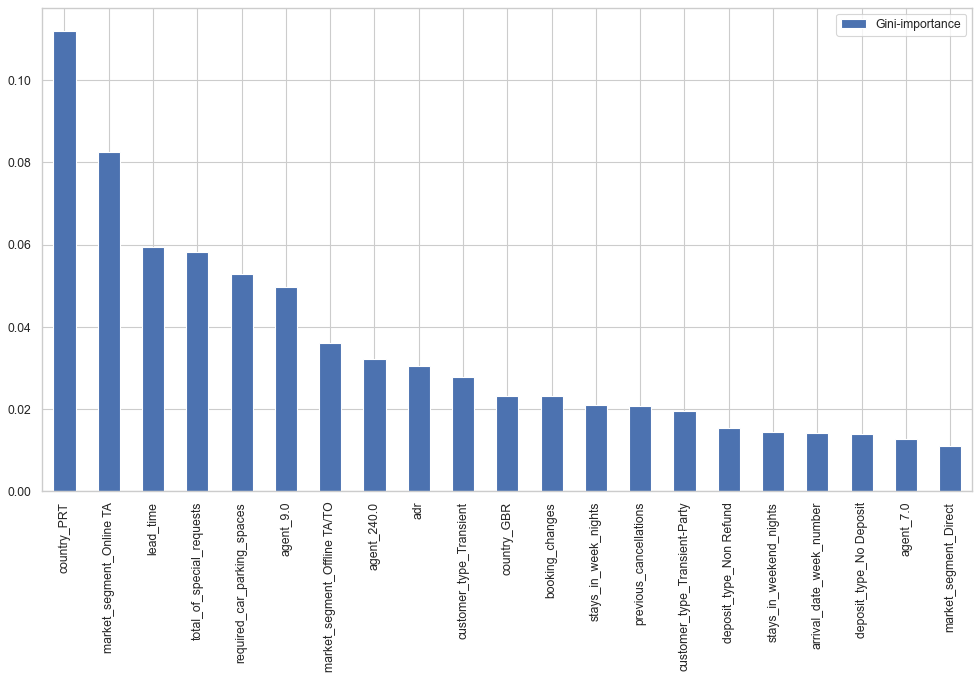

In [60]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(std_train.columns, RF.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize = (15,8))

top_importance = importances.sort_values(by = "Gini-importance", 
                                         ascending = False).loc[importances["Gini-importance"] > 0.01,:]

top_importance.plot(kind = 'bar', rot = 90, figsize = (15,8))



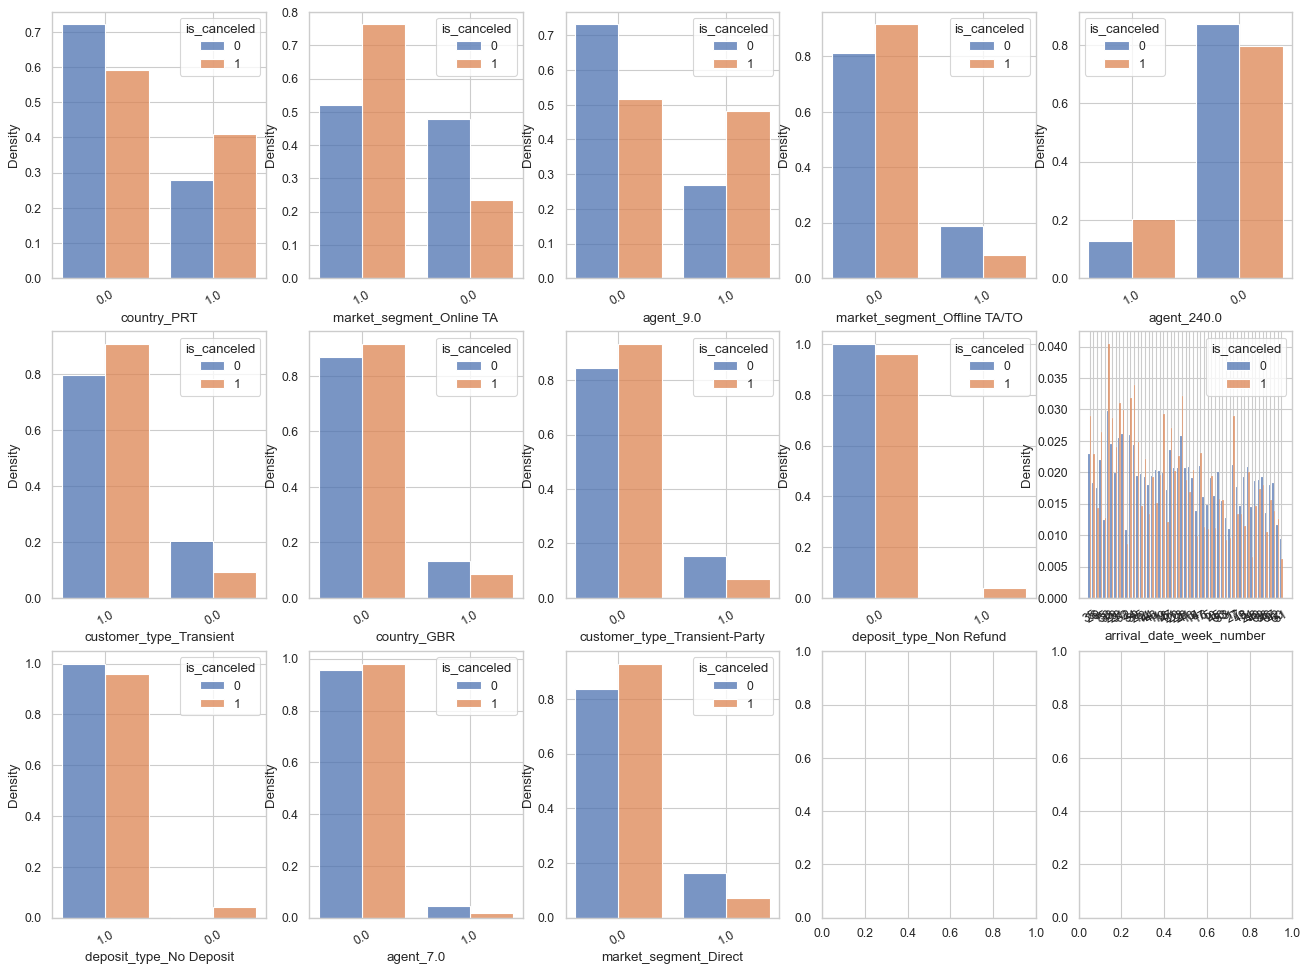

In [61]:
##Plotting barplots of the most important features in test data
##plot categorical variables split by cancellation status
fig, ax = plt.subplots(ncols = 5, nrows =3, figsize = (20, 15))
ax = ax.ravel()
imp_cols = [col for col in top_importance.index if col not in scale_col]##get importance cols that are categorical
data = pd.concat([pd.DataFrame(y_test), std_test], axis = 1) ##combine test response and features for plotting data
data[imp_cols] = data[imp_cols].astype("str")
data[imp_cols] = data[imp_cols].astype("object")

for i in range(len(imp_cols)):
    # p = sns.countplot(x=imp_cols[i], hue = "is_canceled", data = df, ax = ax[i])
    p = sns.histplot(x = imp_cols[i], hue="is_canceled", multiple="dodge", data = data, ax = ax[i],
                     stat = 'density', shrink = 0.8, common_norm=False)
    for item in p.get_xticklabels():
        item.set_rotation(30)
    p

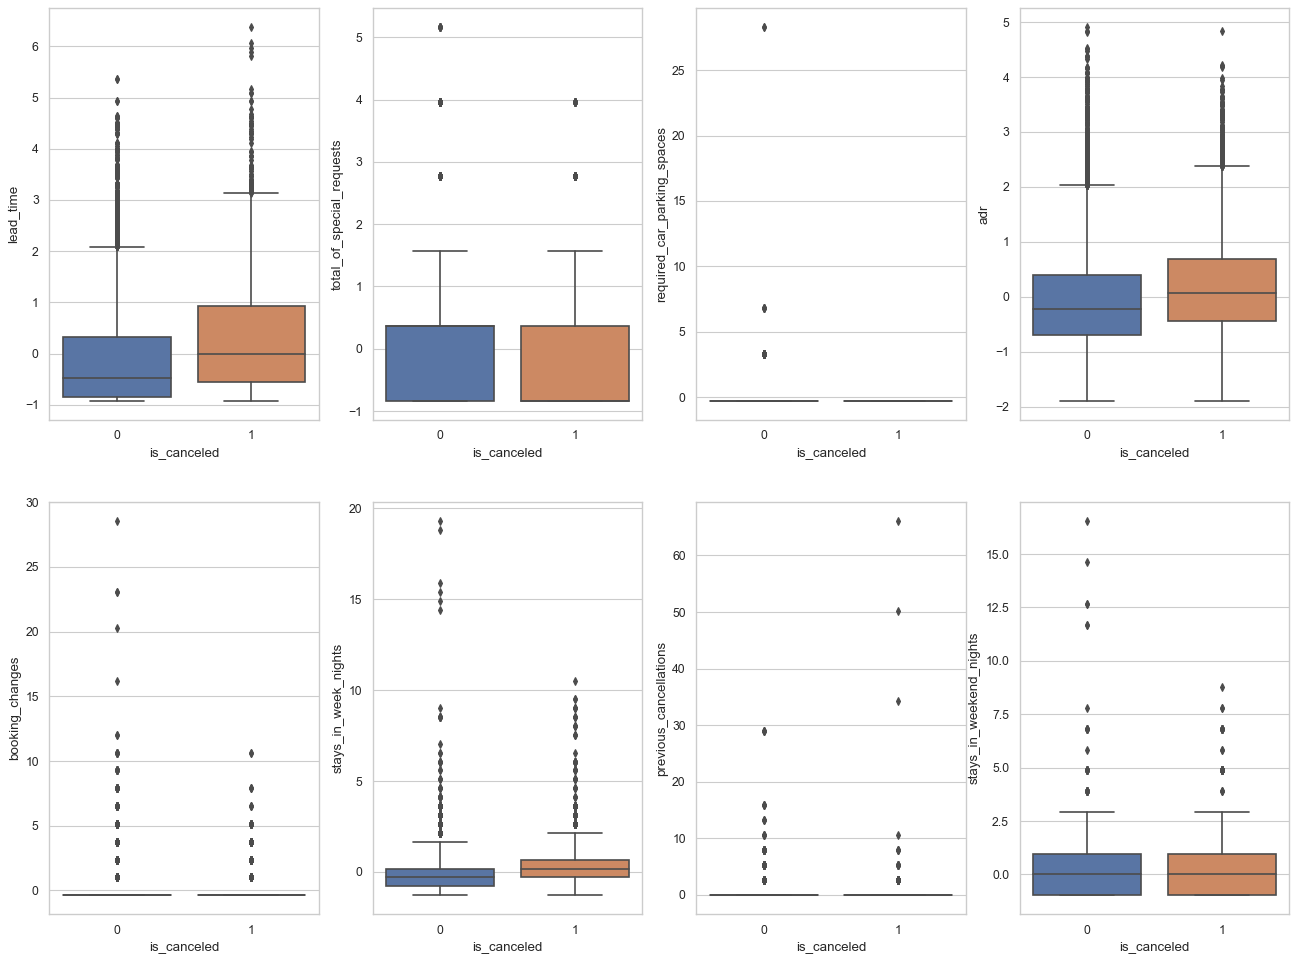

In [62]:
fig, ax2 = plt.subplots(ncols = 4, nrows =2, figsize = (20, 15))
ax2 = ax2.ravel()
imp_cols_num = [col for col in top_importance.index if col in scale_col]

for i in range(len(imp_cols_num)):
    sns.boxplot(y=imp_cols_num[i], x = "is_canceled", data = data, ax = ax2[i])

The plot of Gini importances above shows the top 20 most important features. The biggest factor is the country indicator variable indicating whether a booking was from Portugal or not. We plotted density box-plots of the categorical variables (split by cancellation status) and box and whisker plots of the numerical variables (split by cancellation status).

Some of the important features do not show a clear difference between cancelled and not-cancelled; however, some do show a clear difference, so we can identify the direction of effect for these variables.

The categorical variable plots can be difficult to interpret at first glance. To help interpret, we will walk through the interpretation of country_PRT. country_PRT is an indicator variable that takes the value "1" if the booking was made from Portugal and "0" if it was made elsewhere. The status of country_PRT is on the x-axis. We have also split the data by cancellation status, so yellow indicates data for cancelled bookings and blue indicates data for non-cancelled bookings. The y-axis represents the proportion of overall bookings (stratified by cancellation status) that were booked in Portugal or not in Portugal. 

Considering this, it appears that approximately 40% of cancelled bookings (yellow) were made in Portugal while 60% of cancelled bookings were made outside of Portugal, suggesting that cancellations are less likely when booked in Portugal. We interpreted the remaining categorical variables with a similar method.

Keeping this in mind, it appears that cancellations are less likely when bookings are made outside of Portugal, bookings are made from the offline TA/TO segment, agent 240 is used, bookings are made from Great Britain, customer type is transient-party, deposit type is non-refund, agent 7 is used, or bookings are made from the direct market segment.

Conversely, it appears that cancellations are more likely when bookings are made from the online TA segment or customer type is transient.

The numerical variables are a bit easier to interpret; if the overall mean is higher in cancellations than non-cancellations, that variable is more likely to cause cancellations. Overall, most numerical variables do not have a clear visual difference; however, some do.

It is clear that cancellations are more likely for longer lead times, higher adr values, and higher number of stays on weeknights. 

It is not immediately clear which numerical variables reduce the likelihood of cancellation; however, it is possible that the total number of special requests and requested parking spaces might reduce the likelihood of cancellation since the outliers go higher in the non-cancellation group.

Overall the interpretation is that cancellation is more likely for bookings made far in advance, with a high number of lodging transactions per day, and many weeknights for transient customers who booked online through a TA segment. Most of these make sense; for instance, longer lead times mean there is more time for plans to change (and get cancelled). Additionally, transient customers are less loyal to the brand, so they have less reason to stay at the hotel rather than switch.

On the flip side, it is clear that some agents seem to be reliable bookers (agent 7 and 240), country of origin matters (customers from Portugal and Great Britain are less likely to cancel), and type of payment (deposit, non-refundable, etc) can impact cancellation.

### *Overbooking vs Underbooking*

We have mentioned that a hotel would likely prefer to overbook rooms to maximize the profits and reduce losses from empty rooms. It follows, then, that the ratio of overbooking to underbooking is important. Consequently, we decided to look at how well our model predicts overbooking and underbooking. 

For a binary classification model like this one, we technically have 1 correct outcome and 3 incorrect outcomes. For instance, say we have family A and family B both booked for the same room (at the same time), yet Family B will eventually cancel their booking. Assuming we don't know they will cancel beforehand, our model could accurately predict the outcome in 1 way (Family B cancels and Family A does not) and it could incorrectly predict the outcome in 3 ways (Neither cancel, both cancel, Family A cancels but not Family B). 

However, when all we care about is overbookings and underbookings, we actually have 2 correct predictions and 2 incorrect predictions. For instance, the (technically incorrect) prediction that Family A cancels but Family B does not (reversed from the truth) is still a desirable outcome because all the hotel cares about is whether we predict the correct number of cancellations not *which* groups cancel. In essence, it only matters whether we accurately predict that one of them cancels. Thus, although this is a classification problem, we can evaluate our results as a regression model. 

Considering this "new" classification or "regression" setup, we can visualize overbookings and underbookings by plotting the true number of cancellations per week against the predicted number of cancellations per week. The plot is shown below.

In [63]:
##using the time dataframe we created earlier
positive = X_test[y_pred == 1]
positive = positive.join(timedf[timedf.index.isin(X_test.index)][["arrival_date_year","date"]])
true = X_test[y_test == 1]
true = true.join(timedf[timedf.index.isin(X_test.index)][["arrival_date_year","date"]])


# create start date and end date of each booking
positive["end_date"] = positive.apply(lambda x:x.date + pd.DateOffset(days = (x.stays_in_week_nights + x.stays_in_weekend_nights - 1)), axis = 1)
true["end_date"] = true.apply(lambda x:x.date + pd.DateOffset(days = (x.stays_in_week_nights + x.stays_in_weekend_nights - 1)), axis = 1)

# Check the amount of cancelled nights(true and predict) for each date 
date_range = pd.date_range(start=min([positive.date.min(),true.date.min()]),end= max([positive.date.max(),true.date.max()]))

t_cancel = []
p_cancel = []
for i in range(len(date_range)):
    true_cancel = (date_range[i] >= true.date) & (date_range[i] <= true.end_date)
    positive_cancel =(date_range[i] >= positive.date) & (date_range[i] <= positive.end_date)
    t_cancel.append(sum(true_cancel))
    p_cancel.append(sum(positive_cancel))

# combine them into a datafarme
all_sum = pd.DataFrame({"date" : date_range, "true_cancel" : t_cancel, 
                        "predicted_cancel": p_cancel})




R^2 for the predicted weekly total:
0.916005586313708


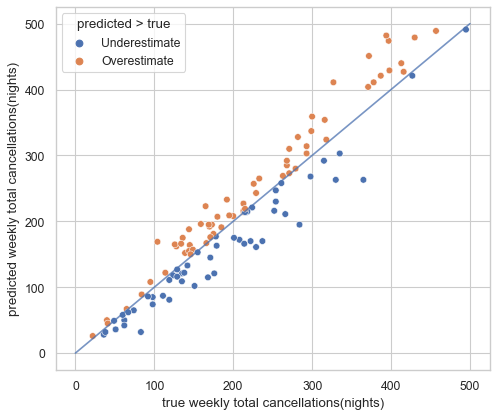

In [64]:
# group the data by week and year to for weekly totals
all_sum["year"] = all_sum.date.dt.year
all_sum["week"] = all_sum.date.dt.isocalendar().week
all_sum_2 = all_sum.groupby(
    ["year", "week"], as_index = False).agg(
    {"true_cancel" : sum, "predicted_cancel": sum})
all_sum_2["predicted > true"] = np.where(all_sum_2.predicted_cancel > all_sum_2.true_cancel, "Overestimate", "Underestimate")

# look at weekly total
print("R^2 for the predicted weekly total:")
print(r2_score(all_sum_2.predicted_cancel, all_sum_2.true_cancel))

# ploting scatterplot
all_sum_2 = all_sum_2.rename(columns =
    {"true_cancel": "true weekly total cancellations(nights)",
     "predicted_cancel": "predicted weekly total cancellations(nights)"})

sns.set_style("whitegrid")
plt.figure(figsize=(7, 6))
sns.scatterplot(data = all_sum_2,x = "true weekly total cancellations(nights)", y = "predicted weekly total cancellations(nights)", hue = "predicted > true")
plt.plot([0, 500], [0, 500], linewidth=1.5, alpha =.75)


Each data point in the scatter plot represents a weekly total in our test data. On the x-axis, we have the true total number of nights cancelled, while the y-axis represents that prediction from the model. The orange dots are the weeks where our model overestimates the number of cancellations, and the blue the opposite. Following the reasoning above, we see that our model predictions and the true values are highly positively correlated (R^2 = 0.916). We can also see that because of the class weights we assigned to the training set, our model tends to overestimate cancellations per week rather than underestimate, which is the desired outcome. 

### *Summary of Findings and Implications*

Our model clearly identifies key features that influence whether a hotel reservation is cancelled or not. The model indicates that the most important features for cancellation status are country_PRT, market_segment_Online TA, lead_time, total_of_special_requests and required_car_parking_spaces. 

For country_PRT, hotels can look into bookings made by Portuguese citizens since bookings from Portugal appear to indicate a higher chance of cancellation. 

Market segment with online TA suggests that bookings made by online travel agents increase the risk of cancellation. This is potentially correct because it may be easier to make fake/invalid bookings through online travel agents. A potential solution to reduce cancellations is to limit bookings through online travel agents. 

Another critical variable is lead time. Longer lead times increase the chances of cancellation, so hotels can compensate for potential cancellations from long lead times by either setting a maximum booking window or double-booking rooms booked with longer lead times. For example, the guests can only book rooms at most 72 days in advance, thereby reducing the demand for rooms and the number of cancellations.

Since more special requests appear to decrease the likelihood of cancellation, hotels can increase the number of amenities offered to increase the likelihood of special requests (to reduce cancellation). Additionally, when double booking, the hotels can avoid double-booking rooms that have high numbers of requests since these customers are likely to not cancel.

Even though our model has a fairly good predictive quality, it is important to note that it is not perfect and will not always predict cancellations accurately. Due to this limiting factor, a hotel must consider how many rooms to overbook or underbook based on the accuracy of the model. 

We have seen that our model tends to overestimate cancellations rather than underestimate. If a hotel follows our model to the letter, there is a strong chance that they will overbook. If they overbook too many rooms and there are not enough cancellations to ensure each customer has a room, the hotel could run out of rooms for the customers. This is clearly an issue; however, it is common practice for hotels to book rooms at partner hotels for any customers that have been overbooked (often with an upgrade). As long as a strategy like this is in place, there should not be too many negative effects of overbooking. Although it is worth noting that it may result in the loss of repeat customers due to the hassel that a hotel change can cause for an individual that has been overbooked. Nonetheless, the choice must be left to the hotel business owners depending on their priorities.